#### Chapter 30
### Analyzing Neural Time Series Data
Python code for Chapter 30 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.stats import norm

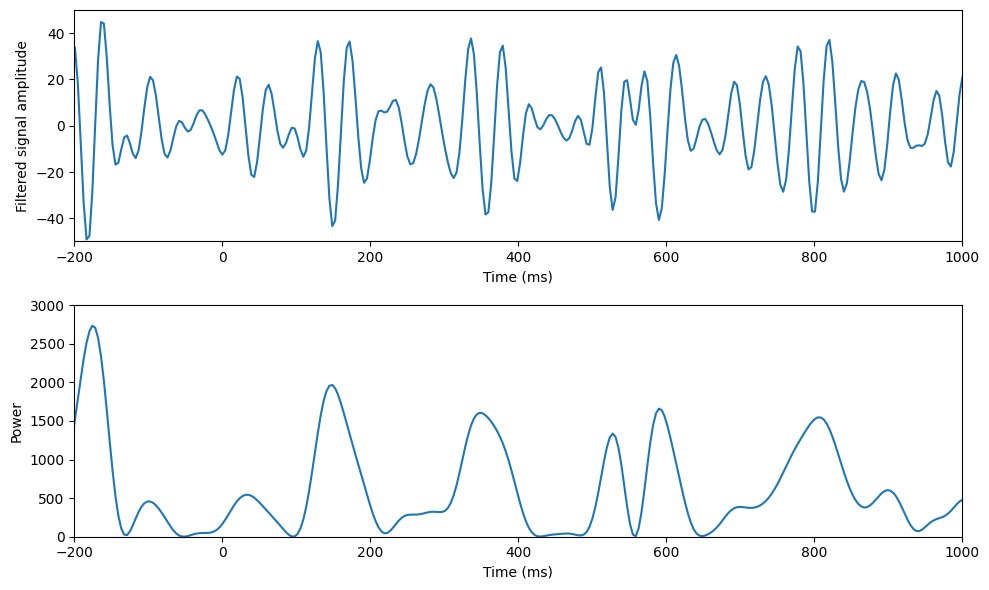

In [ ]:
# Figure 30.1

# Load data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Define channel to plot
channel2plot = 'O1'

# Wavelet parameters
freq2plot = 25

# Other wavelet parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_of_wavelet_size = (len(time)-1)//2
n_wavelet = len(time)
n_data = EEG['pnts'][0][0]*EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# Find sensor index
sensoridx = EEG['chanlocs'][0]['labels']==channel2plot

# FFT of data
fft_EEG = fft(EEG['data'][sensoridx, :, :].flatten('F'), n_convolution)

# Create wavelet and get its FFT
wavelet = np.exp(2*1j*np.pi*freq2plot*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq2plot))**2))
fft_wavelet = fft(wavelet, n_convolution)

convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
convolution_result = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(211)
plt.plot(EEG['times'][0], np.real(convolution_result[:, 0])) # Filtered signal from the first trial
plt.xlabel('Time (ms)'), plt.ylabel('Filtered signal amplitude')
plt.xlim([-200, 1000])
plt.ylim([-50, 50])

plt.subplot(212)
plt.plot(EEG['times'][0], np.abs(convolution_result[:, 0])**2) # Power from the first trial
plt.xlabel('Time (ms)'), plt.ylabel('Power')
plt.xlim([-200, 1000])
plt.ylim([0, 3000])

plt.tight_layout()
plt.show()

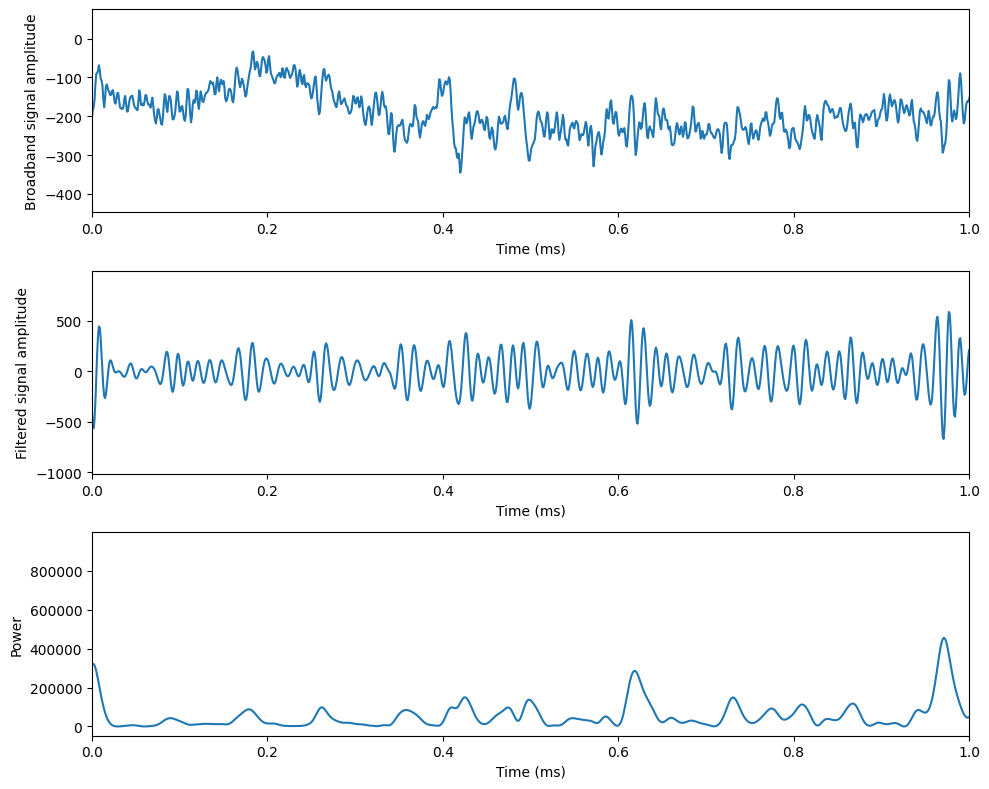

In [ ]:
# Figure 30.2

# Load data
eeg = loadmat('../data/accumbens_eeg.mat')['eeg'][0]
srate = 1000

# Wavelet parameters
freq2plot = 70

# Other wavelet parameters
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = (len(time)-1)//2
n_wavelet = len(time)
n_data = len(eeg)
n_convolution = n_wavelet + n_data - 1

# FFT of data
fft_EEG = fft(eeg, n_convolution)

# Create wavelet and get its FFT
wavelet = np.exp(2*1j*np.pi*freq2plot*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq2plot))**2))
fft_wavelet = fft(wavelet, n_convolution)

convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]

eegtime = np.arange(0, len(eeg)) / srate

# Plotting
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(eegtime, eeg)
plt.xlabel('Time (ms)'), plt.ylabel('Broadband signal amplitude')
plt.xlim([0, 1])

plt.subplot(312)
plt.plot(eegtime, np.real(convolution_result)) # Filtered signal from the first trial
plt.xlabel('Time (ms)'), plt.ylabel('Filtered signal amplitude')
plt.xlim([0, 1])

plt.subplot(313)
plt.plot(eegtime, np.abs(convolution_result)**2) # Power from the first trial
plt.xlabel('Time (ms)'), plt.ylabel('Power')
plt.xlim([0, 1])

plt.tight_layout()
plt.show()

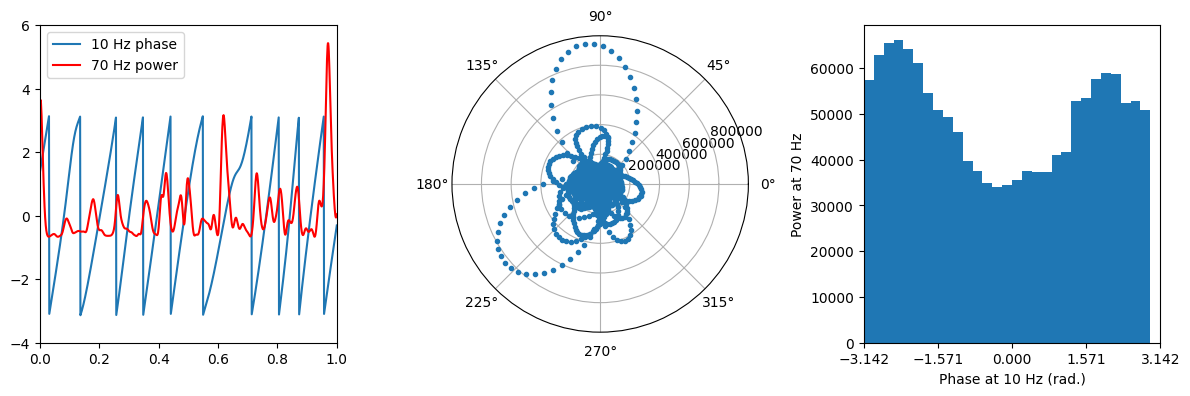

In [ ]:
# Figure 30.3

# We will first test for cross-frequency coupling between two specific frequency bands
freq4phase = 10  # in Hz
freq4power = 70

# Wavelet and FFT parameters
srate = 1000
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = (len(time)-1)//2
n_wavelet = len(time)
n_data = len(eeg)
n_convolution = n_wavelet + n_data - 1
fft_data = fft(eeg, n_convolution)

# Wavelet for phase and its FFT
wavelet4phase = np.exp(2*1j*np.pi*freq4phase*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq4phase))**2))
fft_wavelet4phase = fft(wavelet4phase, n_convolution)

# Wavelet for power and its FFT
wavelet4power = np.exp(2*1j*np.pi*freq4power*time) * np.exp(-time**2 / (2*(4/(2*np.pi*freq4power))**2))
fft_wavelet4power = fft(wavelet4power, n_convolution)

# Get phase values
convolution_result_fft = ifft(fft_wavelet4phase * fft_data, n_convolution)
phase = np.angle(convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size])

# Get power values (note: 'power' is a built-in function so we'll name this variable 'amp')
convolution_result_fft = ifft(fft_wavelet4power * fft_data, n_convolution)
pwr = np.abs(convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size])**2

# Plot power and phase
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(eegtime, phase)
plt.plot(eegtime, (pwr - np.mean(pwr)) / np.std(pwr), 'r')
plt.legend(['10 Hz phase', '70 Hz power'])
plt.xlim([0, 1])
plt.ylim([-4, 6])

# Plot power as a function of phase in polar space
plt.subplot(132, projection='polar')
plt.polar(phase, pwr, '.')

# Plot histogram of power over phase
n_hist_bins = 30
phase_edges = np.linspace(np.min(phase), np.max(phase), n_hist_bins + 1)
amp_by_phases = np.zeros(n_hist_bins)

for i in range(n_hist_bins - 1):
    amp_by_phases[i] = np.mean(pwr[(phase > phase_edges[i]) & (phase < phase_edges[i + 1])])

plt.subplot(133)
plt.bar(phase_edges[:-1], amp_by_phases, align='edge', width=np.diff(phase_edges)[0])
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
plt.xlabel(f'Phase at {freq4phase} Hz (rad.)')
plt.ylabel(f'Power at {freq4power} Hz')

plt.tight_layout()
plt.show()

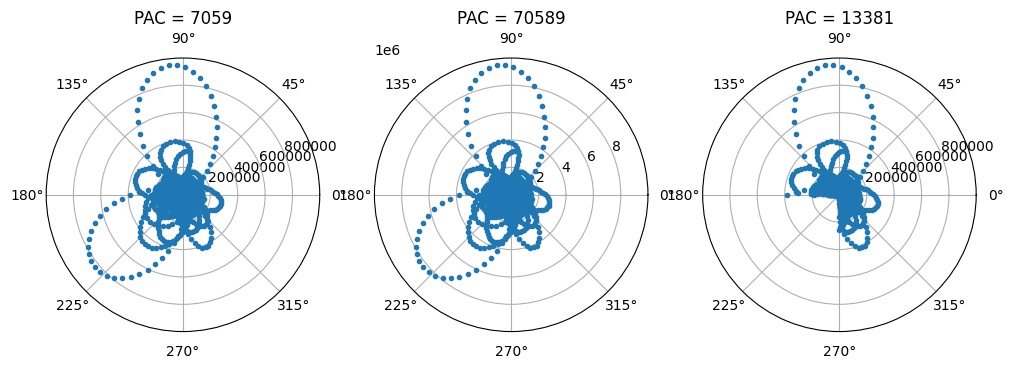

In [ ]:
# Figure 30.4

# Phase bias is the phase time series without the negative half of the cycle
phase_bias = phase[phase >= -np.pi/2]

# Power bias is the corresponding power time series
power_bias = pwr[phase >= -np.pi/2]

# Plot power as a function of phase in polar space
plt.figure(figsize=(12, 4))

plt.subplot(131, projection='polar')
plt.polar(phase, pwr, '.')
plt.title(f'PAC = {np.round(np.abs(np.mean(pwr * np.exp(1j * phase)))):.0f}')

plt.subplot(132, projection='polar')
plt.polar(phase, pwr * 10, '.')
plt.title(f'PAC = {np.round(np.abs(np.mean(pwr * 10 * np.exp(1j * phase)))):.0f}')

plt.subplot(133, projection='polar')
plt.polar(phase_bias, power_bias, '.')
plt.title(f'PAC = {np.round(np.abs(np.mean(power_bias * np.exp(1j * phase_bias)))):.0f}')

plt.show()

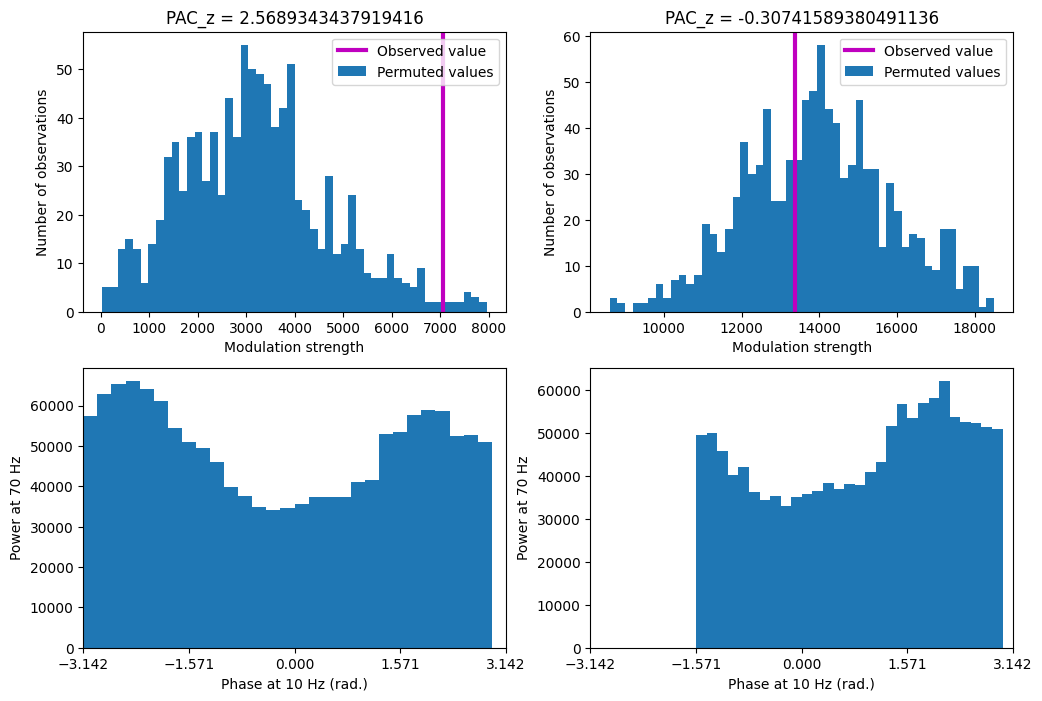

In [ ]:
# Figure 30.5

# Observed cross-frequency coupling (note the similarity to Euler's formula)
obsPAC = np.abs(np.mean(pwr * np.exp(1j * phase)))
obsPAC_bias = np.abs(np.mean(power_bias * np.exp(1j * phase_bias)))

num_iter = 1000
permutedPAC = np.zeros((2, num_iter))

# Permutation test
for i in range(num_iter):
    # Select random time point
    random_timepoint = np.random.choice(np.round(len(eeg) * 0.8).astype(int), 1) + np.round(len(eeg) * 0.1).astype(int)
    random_timepoint_bias = np.random.choice(np.round(len(power_bias) * 0.8).astype(int), 1) + np.round(len(power_bias) * 0.1).astype(int)
    
    # Shuffle power
    timeshiftedpwr = np.concatenate((pwr[random_timepoint[0]:], pwr[:random_timepoint[0]]))
    timeshiftedpwr_bias = np.concatenate((power_bias[random_timepoint_bias[0]:], power_bias[:random_timepoint_bias[0]]))
    
    # Compute PAC
    permutedPAC[0, i] = np.abs(np.mean(timeshiftedpwr * np.exp(1j * phase)))
    permutedPAC[1, i] = np.abs(np.mean(timeshiftedpwr_bias * np.exp(1j * phase_bias)))

# Compute PACz
pacz = np.zeros(2)
pacz[0] = (obsPAC - np.mean(permutedPAC[0, :])) / np.std(permutedPAC[0, :])
pacz[1] = (obsPAC_bias - np.mean(permutedPAC[1, :])) / np.std(permutedPAC[1, :])

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.hist(permutedPAC[0, :], bins=50)
plt.axvline(obsPAC, color='m', linewidth=3)
plt.legend(['Observed value', 'Permuted values'])
plt.xlabel('Modulation strength'), plt.ylabel('Number of observations')
plt.title(f'PAC_z = {pacz[0]}')

plt.subplot(222)
plt.hist(permutedPAC[1, :], bins=50)
plt.axvline(obsPAC_bias, color='m', linewidth=3)
plt.legend(['Observed value', 'Permuted values'])
plt.xlabel('Modulation strength'), plt.ylabel('Number of observations')
plt.title(f'PAC_z = {pacz[1]}')

# Plot histogram of power over phase
n_hist_bins = 30
phase_edges = np.linspace(np.min(phase), np.max(phase), n_hist_bins + 1)
amp_by_phases = np.zeros(n_hist_bins)

for i in range(n_hist_bins - 1):
    amp_by_phases[i] = np.mean(pwr[(phase > phase_edges[i]) & (phase < phase_edges[i + 1])])

plt.subplot(223)
plt.bar(phase_edges[:-1], amp_by_phases, align='edge', width=np.diff(phase_edges)[0])
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
plt.xlabel(f'Phase at {freq4phase} Hz (rad.)')
plt.ylabel(f'Power at {freq4power} Hz')

# Plot histogram of power over phase bias
phase_edges_bias = np.linspace(np.min(phase_bias), np.max(phase_bias), n_hist_bins + 1)
amp_by_phases_bias = np.zeros(n_hist_bins)

for i in range(n_hist_bins - 1):
    amp_by_phases_bias[i] = np.mean(power_bias[(phase_bias > phase_edges_bias[i]) & (phase_bias < phase_edges_bias[i + 1])])

plt.subplot(224)
plt.bar(phase_edges_bias[:-1], amp_by_phases_bias, align='edge', width=np.diff(phase_edges_bias)[0])
plt.xlim([-np.pi, np.pi])
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
plt.xlabel(f'Phase at {freq4phase} Hz (rad.)')
plt.ylabel(f'Power at {freq4power} Hz')

plt.show()

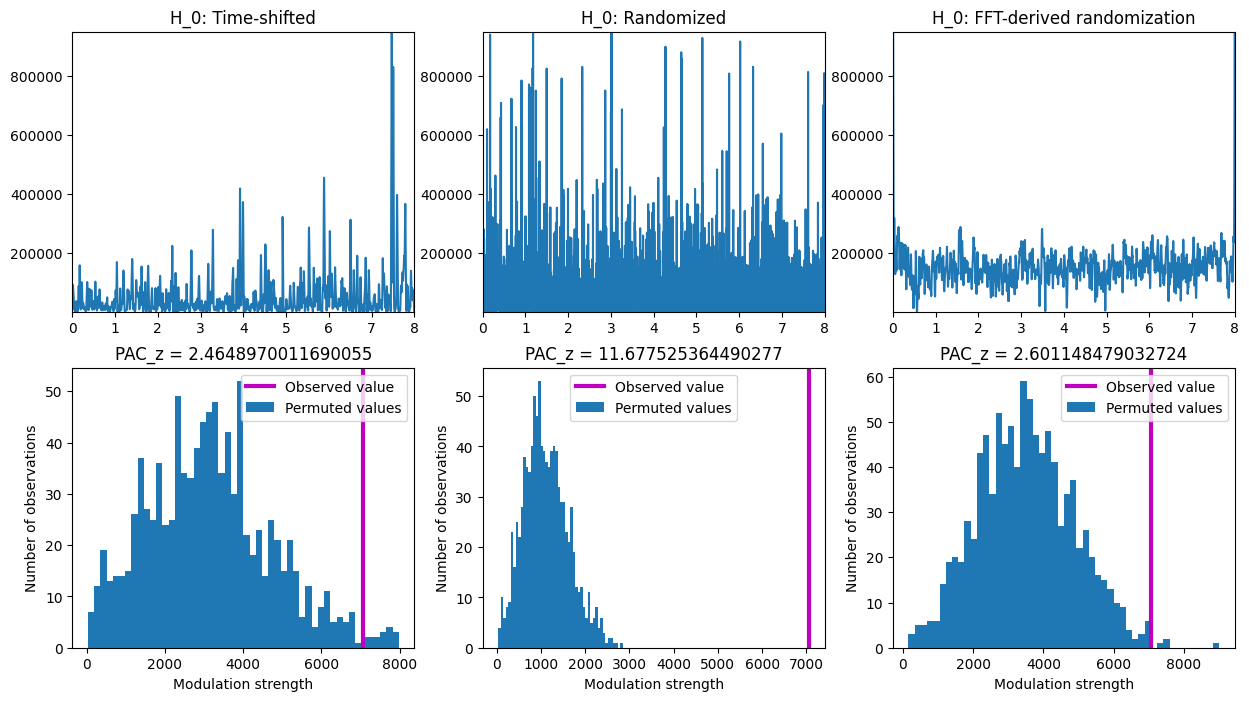

In [ ]:
# Figure 30.6

# Initialize the array to store permuted PAC values for three different permutation methods
permutedPAC = np.zeros((3, num_iter))

# Permutation tests
for i in range(num_iter):
    
    # Permutation method 1: select random time point
    random_timepoint = np.random.choice(np.round(len(eeg) * 0.8).astype(int), 1) + np.round(len(eeg) * 0.1).astype(int)
    timeshiftedpwr = np.concatenate((pwr[random_timepoint[0]:], pwr[:random_timepoint[0]]))
    permutedPAC[0, i] = np.abs(np.mean(timeshiftedpwr * np.exp(1j * phase)))
    
    # Permutation method 2: totally randomize power time series
    permutedPAC[1, i] = np.abs(np.mean(pwr[np.random.permutation(len(pwr))] * np.exp(1j * phase)))
    
    # Permutation method 3: FFT-based power time series randomization
    f = fft(pwr)  # compute FFT
    A = np.abs(f)  # extract amplitudes
    zphs = np.cos(np.angle(f)) + 1j * np.sin(np.angle(f))  # extract phases
    powernew = np.real(ifft(A * zphs[np.random.permutation(len(zphs))]))  # recombine using randomized phases
    powernew = powernew - np.min(powernew)
    
    permutedPAC[2, i] = np.abs(np.mean(powernew * np.exp(1j * phase)))

# Compute PACz and plot
plt.figure(figsize=(15, 8))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    
    # Plot example power time series
    if i == 0:
        plt.plot(eegtime, timeshiftedpwr)
        plt.title('H_0: Time-shifted')
    elif i == 1:
        plt.plot(eegtime, pwr[np.random.permutation(len(pwr))])
        plt.title('H_0: Randomized')
    elif i == 2:
        plt.plot(eegtime, powernew)
        plt.title('H_0: FFT-derived randomization')
    
    plt.xlim([0, eegtime[-1]])
    plt.ylim([np.min(pwr), np.max(pwr)])
    
    # Plot null-hypothesis distribution
    plt.subplot(2, 3, i + 4)
    pacz = (obsPAC - np.mean(permutedPAC[i, :])) / np.std(permutedPAC[i, :])
    y, x = np.histogram(permutedPAC[i, :], bins=50)
    plt.bar(x[:-1], y, width=np.diff(x), align='edge')
    plt.axvline(obsPAC, color='m', linewidth=3)
    plt.legend(['Observed value', 'Permuted values'])
    plt.xlabel('Modulation strength'), plt.ylabel('Number of observations')
    plt.title(f'PAC_z = {pacz}')

plt.show()

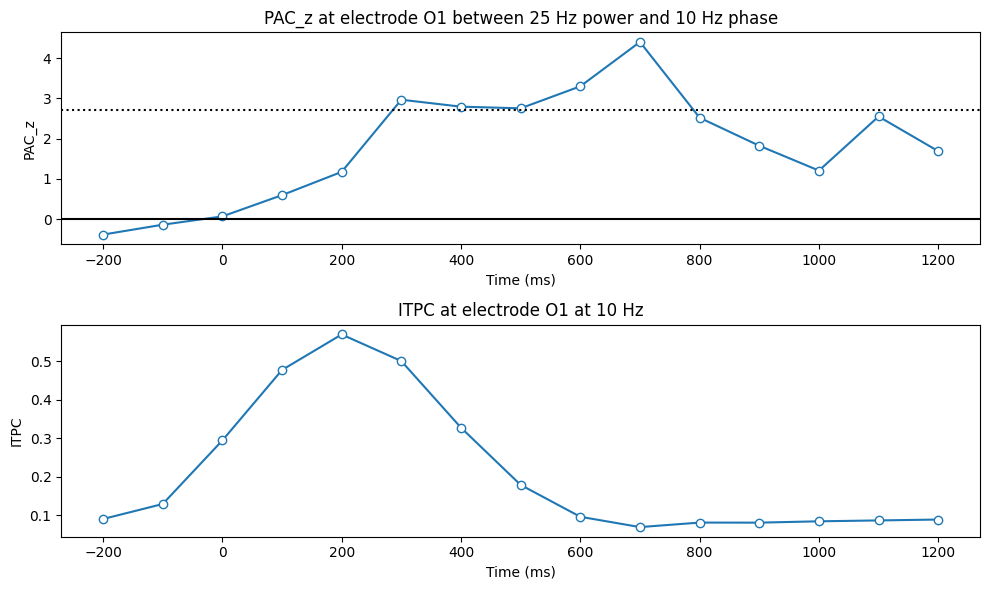

In [ ]:
# Figure 30.7

# Define the time points to plot
times2plot = np.arange(-200, 1201, 100)
freq4phase = 10  # Hz for phase
freq4power = 25  # Hz for power

cfc_numcycles = 3  # number of cycles at phase-frequency

pacz = np.zeros(len(times2plot))
itpc = np.zeros(len(times2plot))

# Convert cfc times to indices
cfc_time_window = cfc_numcycles * (1000 / freq4phase)
cfc_time_window_idx = np.round(cfc_time_window / (1000 / EEG['srate'][0][0])).astype(int)

# Other wavelet parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_of_wavelet_size = (len(time)-1)//2
n_wavelet = len(time)
n_data = EEG['pnts'][0][0]*EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# FFT of scalp EEG data
fft_EEG = fft(EEG['data'][sensoridx, :, :].flatten('F'), n_convolution)

for timei, timepoint in enumerate(times2plot):
    
    cfc_centertime_idx = np.argmin(np.abs(EEG['times'][0] - timepoint))
    
    # Convolution for lower frequency phase
    wavelet = np.exp(2 * 1j * np.pi * freq4phase * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq4phase))**2))
    fft_wavelet = fft(wavelet, n_convolution)
    convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    lower_freq_phase = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Convolution for upper frequency power
    wavelet = np.exp(2 * 1j * np.pi * freq4power * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq4power))**2))
    fft_wavelet = fft(wavelet, n_convolution)
    convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    upper_freq_power = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Extract temporally localized power and phase
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])

    # Compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    # Compute lower frequency ITPC
    itpc[timei] = np.mean(np.abs(np.mean(np.exp(1j * phase_ts), axis=1)))
    
    # Permutation test
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        random_timepoint = np.random.choice(np.round(cfc_time_window_idx * 0.8).astype(int), EEG['trials'][0][0]) + np.round(cfc_time_window_idx * 0.1).astype(int)
        for triali in range(EEG['trials'][0][0]):
            power_ts[:, triali] = np.roll(power_ts[:, triali], random_timepoint[triali])
        
        permutedPAC[i] = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    pacz[timei] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(211)
plt.plot(times2plot, pacz, '-o', markerfacecolor='w')

# Calculate the z-value threshold for p=0.05, correcting for multiple comparisons
zval = norm.ppf(1 - (0.05 / len(times2plot)))

plt.axhline(zval, color='k', linestyle=':')
plt.axhline(0, color='k')
plt.xlabel('Time (ms)'), plt.ylabel('PAC_z')
plt.title(f'PAC_z at electrode {channel2plot} between {freq4power} Hz power and {freq4phase} Hz phase')

# Also plot ITPC for comparison
plt.subplot(212)
plt.plot(times2plot, itpc, '-o', markerfacecolor='w')
plt.xlabel('Time (ms)'), plt.ylabel('ITPC')
plt.title(f'ITPC at electrode {channel2plot} at {freq4phase} Hz')

plt.tight_layout()
plt.show()

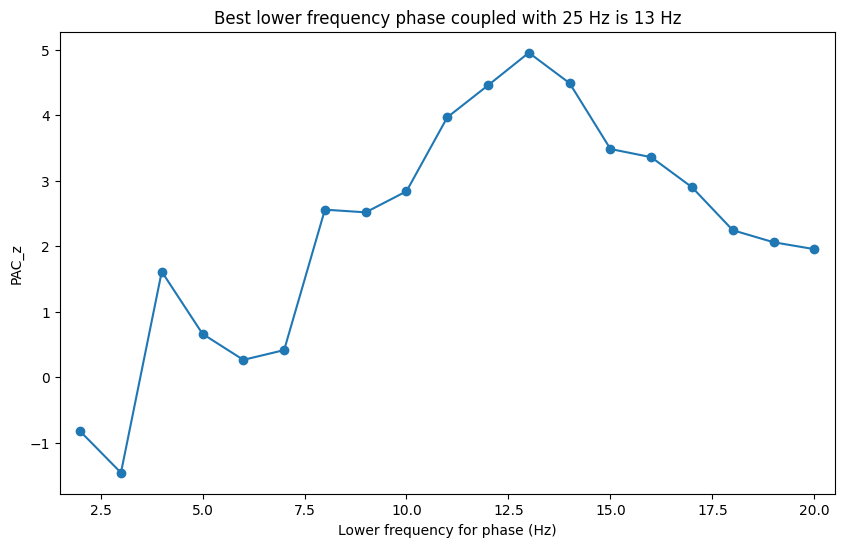

In [ ]:
# Figure 30.8a

# Define the phase frequencies to explore
phase_freqs = np.arange(2, 21)  # Hz
cfc_centertime = 300  # ms post-stimulus
pacz = np.zeros(len(phase_freqs))
cfc_centertime_idx = np.argmin(np.abs(EEG['times'][0] - cfc_centertime))

# Loop over phase frequencies
for fi, pfreq in enumerate(phase_freqs):
    
    # Convolution for lower frequency phase
    wavelet = np.exp(2 * 1j * np.pi * pfreq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * pfreq))**2))
    fft_wavelet = fft(wavelet, n_convolution)
    convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    lower_freq_phase = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Extract temporally localized power and phase
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])
    
    # Compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    # Permutation test
    num_iter = 2000
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        random_timepoint = np.random.choice(np.round(cfc_time_window_idx * 0.8).astype(int), EEG['trials'][0][0]) + np.round(cfc_time_window_idx * 0.1).astype(int)
        for triali in range(EEG['trials'][0][0]):
            power_ts[:, triali] = np.roll(power_ts[:, triali], random_timepoint[triali])
        
        permutedPAC[i] = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    pacz[fi] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(phase_freqs, pacz, '-o')
plt.xlim([phase_freqs[0] - 0.5, phase_freqs[-1] + 0.5])
plt.xlabel('Lower frequency for phase (Hz)'), plt.ylabel('PAC_z')
max_phase_freq = phase_freqs[np.argmax(pacz)]
plt.title(f'Best lower frequency phase coupled with {freq4power} Hz is {max_phase_freq} Hz')
plt.show()

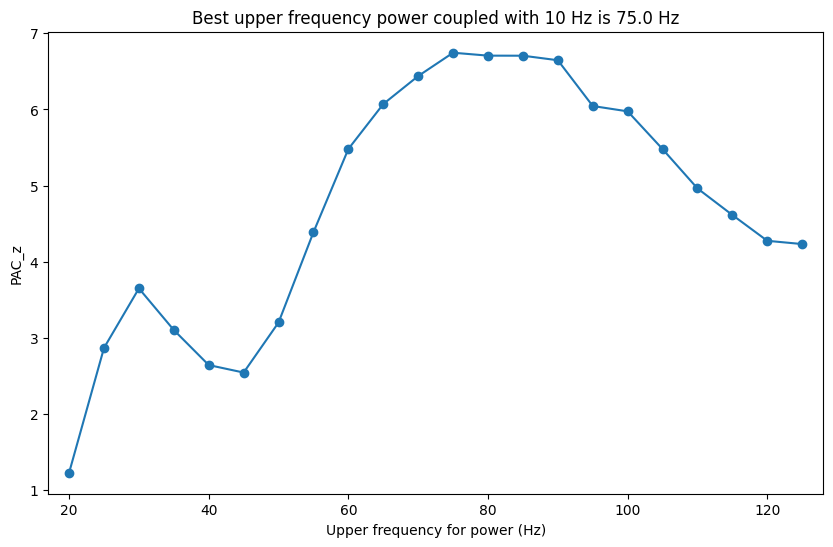

In [ ]:
# Figure 30.8b

# Define the power frequencies to explore
power_freqs = np.arange(20, EEG['srate'][0][0]/2 + 1, 5)  # Hz
pacz = np.zeros(len(power_freqs))

# convolution for lower frequency phase
wavelet = np.exp(2 * 1j * np.pi * freq4phase * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * freq4phase))**2))
fft_wavelet = fft(wavelet, n_convolution)
convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
lower_freq_phase = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Loop over power frequencies
for fi, pwr_freq in enumerate(power_freqs):
    
    # Convolution for upper frequency power
    wavelet = np.exp(2 * 1j * np.pi * pwr_freq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * pwr_freq))**2))
    fft_wavelet = fft(wavelet, n_convolution)
    convolution_result = ifft(fft_wavelet * fft_EEG, n_convolution)
    convolution_result = convolution_result[half_of_wavelet_size:-half_of_wavelet_size]
    upper_freq_power = np.reshape(convolution_result, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Extract temporally localized power and phase
    power_ts = np.abs(upper_freq_power[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])**2
    phase_ts = np.angle(lower_freq_phase[cfc_centertime_idx - np.floor(cfc_time_window_idx/2+0.5).astype(int):cfc_centertime_idx + np.floor(cfc_time_window_idx/2+0.5).astype(int) + 1, :])
    
    # Compute observed PAC
    obsPAC = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    # Permutation test
    num_iter = 2000
    permutedPAC = np.zeros(num_iter)
    for i in range(num_iter):
        random_timepoint = np.random.choice(np.round(cfc_time_window_idx * 0.8).astype(int), EEG['trials'][0][0]) + np.round(cfc_time_window_idx * 0.1).astype(int)
        for triali in range(EEG['trials'][0][0]):
            power_ts[:, triali] = np.roll(power_ts[:, triali], random_timepoint[triali])
        
        permutedPAC[i] = np.abs(np.mean(power_ts.flatten('F') * np.exp(1j * phase_ts.flatten('F'))))
    
    pacz[fi] = (obsPAC - np.mean(permutedPAC)) / np.std(permutedPAC)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(power_freqs, pacz, '-o')
plt.xlim([power_freqs[0] - 3, power_freqs[-1] + 3])
plt.xlabel('Upper frequency for power (Hz)'), plt.ylabel('PAC_z')
max_power_freq = power_freqs[np.argmax(pacz)]
plt.title(f'Best upper frequency power coupled with {freq4phase} Hz is {max_power_freq} Hz')
plt.show()

In [ ]:
# Figure 30.9

# You have to figure this one out on your own!

In [ ]:
# Figure 30.10

# This figure is created by combining the code for figure 30.8. You need
# two loops, one for lower-frequency phase and one for upper-frequency
# power. Compute PAC at each phase-power pair, and then make an image of
# the resulting (z-scored) PAC values. 

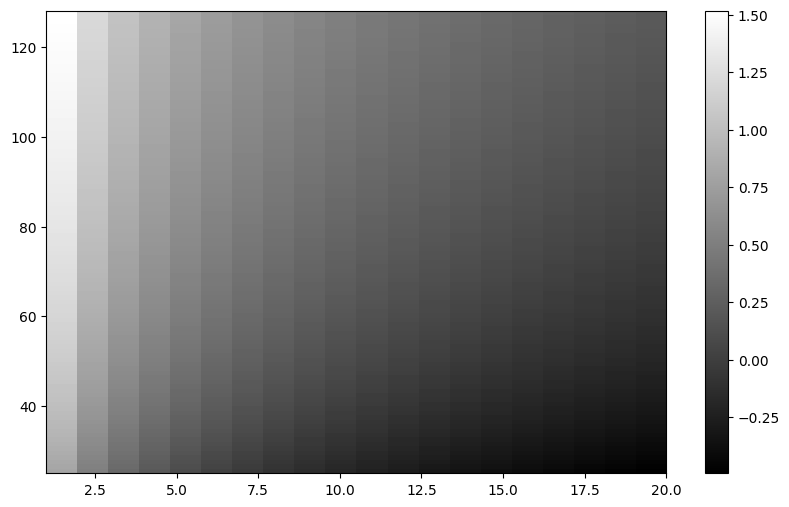

In [ ]:
# Figure 30.11

# Define the frequencies for phase and power
freqs4phase = np.arange(1, 21)
freqs4power = np.arange(25, int(EEG['srate'][0][0] / 2) + 1)

# Initialize the matrix to store the number of power cycles per phase cycle
powcycles_per_phscycles = np.zeros((len(freqs4power), len(freqs4phase)))

# Loop over phase and power frequencies
for phsi, pfreq in enumerate(freqs4phase):
    for powi, pwr_freq in enumerate(freqs4power):
        # Number of power cycles per phase cycle, scaled by sampling rate
        powcycles_per_phscycles[powi, phsi] = (pwr_freq / pfreq) / (1000 / EEG['srate'][0][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(np.log10(powcycles_per_phscycles), extent=[freqs4phase[0], freqs4phase[-1], freqs4power[0], freqs4power[-1]], aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.show()

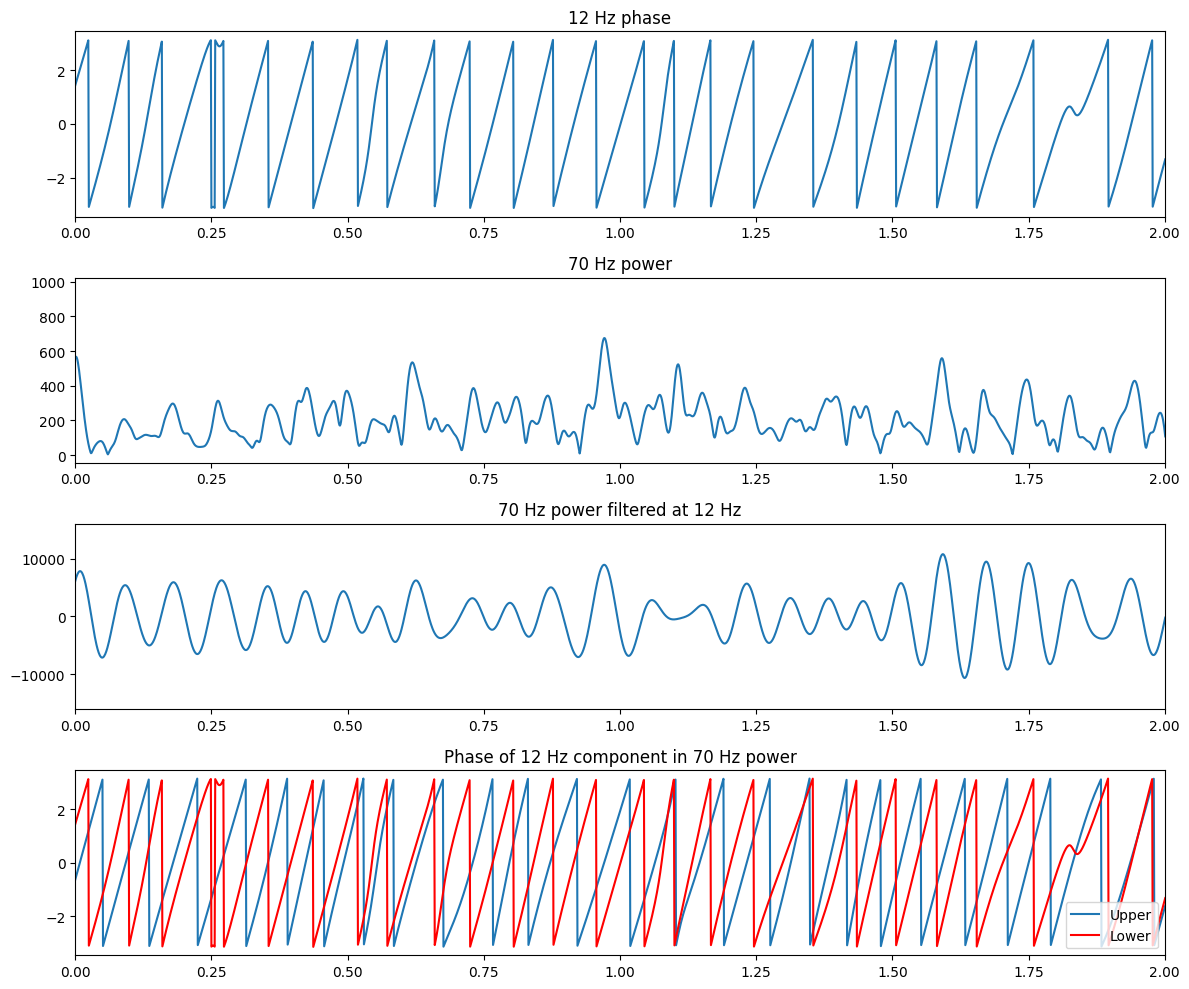

Phase-phase coupling between 12 Hz and 70 Hz is 0.27535


In [ ]:
# Figure 30.12

# Define wavelet parameters
upperfreq = 70
lowerfreq = 12

# Other wavelet parameters
time = np.arange(-1, 1 + 1/srate, 1/srate)
half_of_wavelet_size = (len(time)-1)//2
n_wavelet = len(time)
n_data = len(eeg)
n_convolution = n_wavelet + n_data - 1

# FFT of data
fft_EEG = fft(eeg, n_convolution)

# Convolution for lower frequency phase (with 4 cycles)
waveletL = np.exp(2*1j*np.pi*lowerfreq*time) * np.exp(-time**2 / (2*(4/(2*np.pi*lowerfreq))**2))
fft_waveletL = fft(waveletL, n_convolution)
convolution_resultL = ifft(fft_waveletL * fft_EEG, n_convolution)
lowerfreq_phase = np.angle(convolution_resultL[half_of_wavelet_size:-half_of_wavelet_size])

# Convolution for upper frequency (with 4 cycles)
waveletH = np.exp(2*1j*np.pi*upperfreq*time) * np.exp(-time**2 / (2*(4/(2*np.pi*upperfreq))**2))
fft_waveletH = fft(waveletH, n_convolution)
convolution_resultH = ifft(fft_waveletH * fft_EEG, n_convolution)
upperfreq_amp = np.abs(convolution_resultH[half_of_wavelet_size:-half_of_wavelet_size])

# Filter the upper frequency power in the lower frequency range
convolution_result_filtered = ifft(fft_waveletL * fft(upperfreq_amp, n_convolution), n_convolution)
upperfreq_amp_phase = np.angle(convolution_result_filtered[half_of_wavelet_size:-half_of_wavelet_size])

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(eegtime, lowerfreq_phase)
plt.xlim([0, 2])
plt.title(f'{lowerfreq} Hz phase')

plt.subplot(412)
plt.plot(eegtime, upperfreq_amp)
plt.xlim([0, 2])
plt.title(f'{upperfreq} Hz power')

plt.subplot(413)
plt.plot(eegtime, np.real(convolution_result_filtered[half_of_wavelet_size:-half_of_wavelet_size]))
plt.xlim([0, 2])
plt.title(f'{upperfreq} Hz power filtered at {lowerfreq} Hz')

plt.subplot(414)
plt.plot(eegtime, upperfreq_amp_phase)
plt.plot(eegtime, lowerfreq_phase, 'r')
plt.legend(['Upper', 'Lower'])
plt.xlim([0, 2])
plt.title(f'Phase of {lowerfreq} Hz component in {upperfreq} Hz power')

plt.tight_layout()
plt.show()

# Compute synchronization
phasephase_synch = np.abs(np.mean(np.exp(1j * (lowerfreq_phase - upperfreq_amp_phase))))
print(f'Phase-phase coupling between {lowerfreq} Hz and {upperfreq} Hz is {phasephase_synch:.5f}')